In [1]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=5)

%load_ext autoreload
%autoreload 2

In [2]:
ok.__version__

'1.4.4'

## Problem with minimize_risk

In [7]:
ef = ok.EfficientFrontierReb(['SP500TR.INDX', 'MCFTR.INDX', 'GC.COMM'], ccy='RUB', last_date='2020-03', full_frontier=True)
ef

symbols               [SP500TR.INDX, MCFTR.INDX, GC.COMM]
currency                                              RUB
first_date                                        1997-10
last_date                                         2020-03
period_length                          22 years, 6 months
rebalancing_period                                   year
inflation                                            None
dtype: object

<Axes: >

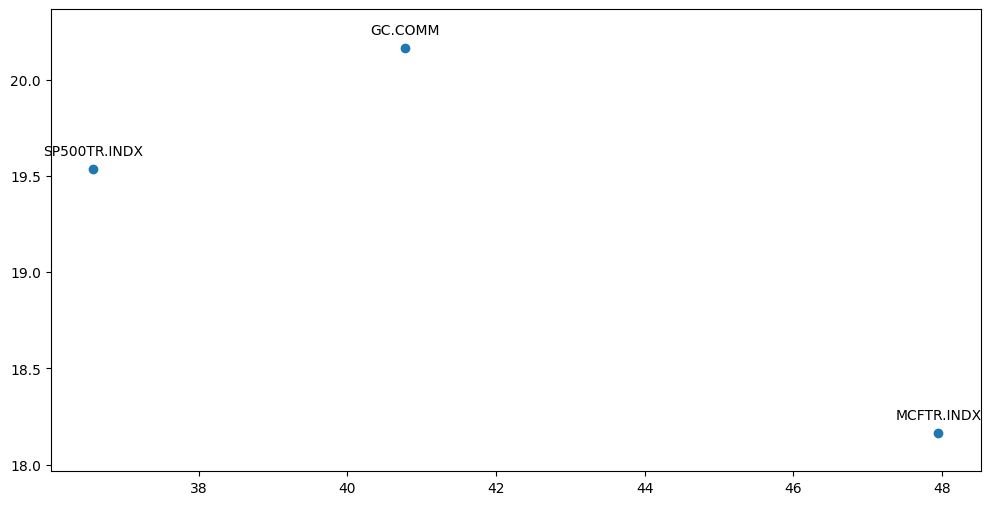

In [12]:
ef.plot_assets(kind="cagr", pct_values=True)

In [8]:
ef.global_max_return_portfolio

{'Weights': array([0.15491, 0.50506, 0.34003]),
 'CAGR': np.float64(0.24350517122785287),
 'Risk': np.float64(0.38121712458127693),
 'Risk_monthly': np.float64(0.08568280954178976)}

In [9]:
ef._target_cagr_range_left

array([0.18166, 0.18491, 0.18817, 0.19142, 0.19468, 0.19793, 0.20119,
       0.20444, 0.2077 , 0.21095, 0.21421, 0.21746, 0.22072, 0.22398,
       0.22723, 0.23049, 0.23374, 0.237  , 0.24025, 0.24351])

In [10]:
ef.minimize_risk(0.18166)

RecursionError: No solution found for target CAGR value: 0.18166.

In [ ]:
w = ef.minimize_risk(0.184914755913651)
print(w)

## Rebalancing strategies

In [3]:
assets = ['RUCBTRNS.INDX', 'MCFTR.INDX', 'GC.COMM']
weights = [0.50, 0.45, 0.05]
# assets = ['SPY.US', 'AGG.US']
# weights = [0.60, 0.40]
pf = ok.Portfolio(assets, weights=weights, ccy='USD', rebalancing_strategy=ok.Rebalance(period="year", abs_deviation=None), inflation=False)

In [21]:
pf.rebalancing_strategy = ok.Rebalance(
    period="year",
    abs_deviation=0.15,
    rel_deviation=0.50
)

In [22]:
print(pf.rebalancing_strategy)

period             year
abs_deviation   0.15000
rel_deviation   0.50000
dtype: object


In [26]:
ev = pf.rebalancing_strategy.wealth_ts(target_weights=weights, ror=pf.assets_ror).events

In [27]:
ev

2005-12    calendar
2008-12    calendar
2010-12    calendar
2024-12    calendar
Freq: M, dtype: object

In [13]:
ev[ev == 'rel'].count()

4

In [14]:
ev[ev == 'abs'].count()

4

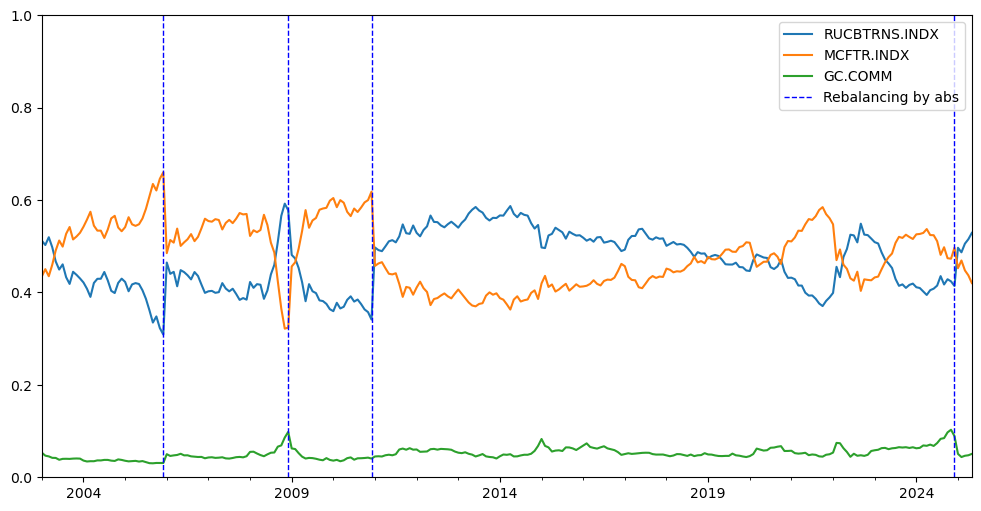

In [28]:
fig = plt.figure(figsize=(12,6))
# fig.subplots_adjust(bottom=0.2, top=1.5)
ax = plt.gca()
pf.weights_ts.plot(ax=ax)
ax.vlines(x=ev[ev == 'calendar'].index, ymin=0, ymax=1, colors='blue', ls='--', lw=1, label='Rebalancing by abs')
# ax.vlines(x=ev[ev == 'rel'].index, ymin=0, ymax=1, colors='yellow', ls='--', lw=1, label='Rebalancing by abs')
ax.set_ylim([0, 1])
ax.legend()


## Cum Return (error fixed)

In [12]:
close = ok.Asset('MCFTR.INDX').close_monthly['2024-12':]

In [13]:
close

date
2024-12   7,112.22000
2025-01   7,306.68000
2025-02   7,932.19000
2025-03   7,468.42000
2025-04   6,806.80000
Freq: M, Name: MCFTR.INDX, dtype: float64

In [20]:
ok.Date.subtract_months(pd.Timestamp('2025-03-15'), months=2)

Timestamp('2025-01-15 00:00:00')

In [14]:
close.pct_change()

date
2024-12        NaN
2025-01    0.02734
2025-02    0.08561
2025-03   -0.05847
2025-04   -0.08859
Freq: M, Name: MCFTR.INDX, dtype: float64

In [ ]:
al = ok.AssetList(['MCFTR.INDX'], ccy='RUB', inflation=False, first_date='2025-01')

Exception ignored in thread started by: <_pydev_bundle.pydev_monkey._NewThreadStartupWithTrace object at 0x000001E66F1FD490>
Traceback (most recent call last):
  File "C:\PyCharm2024\plugins\python-ce\helpers\pydev\pydevd_tracing.py", line 71, in _internal_set_trace
    TracingFunctionHolder._original_tracing(tracing_func)
  File "C:\PyCharm2024\plugins\python-ce\helpers\pydev\pydevd_tracing.py", line 71, in _internal_set_trace
    TracingFunctionHolder._original_tracing(tracing_func)
  File "C:\PyCharm2024\plugins\python-ce\helpers\pydev\pydevd_tracing.py", line 71, in _internal_set_trace
    TracingFunctionHolder._original_tracing(tracing_func)
  [Previous line repeated 997 more times]
RecursionError: maximum recursion depth exceeded


In [28]:
al.wealth_indexes

Symbols,MCFTR.INDX
date,
2024-12,"1,000.00000"
2025-01,"1,027.30000"
2025-02,"1,115.23688"
2025-03,"1,049.99552"
2025-04,956.96592


In [7]:
ror = al.assets_ror
ror

Symbols,MCFTR.INDX
date,
2025-01,0.02730
2025-02,0.08560
2025-03,-0.05850
2025-04,-0.08860


In [8]:
1000 * (ror + 1).cumprod()

Symbols,MCFTR.INDX
date,
2025-01,"1,027.30000"
2025-02,"1,115.23688"
2025-03,"1,049.99552"
2025-04,956.96592


In [10]:
1000 * (ror + 1).cumprod().shift(1)

Symbols,MCFTR.INDX
date,
2025-01,NaN
2025-02,"1,027.30000"
2025-03,"1,115.23688"
2025-04,"1,049.99552"


## List Maker (Parallel)

In [29]:
from okama.common import make_asset_list

ls = ['SPY.US', 'AGG.US', 'GC.COMM', 'VOO.US', 'MCFTR.INDX', 'RGBITR.INDX', 'MOW_PR.RE', 'MOW_SEC.RE', 'RUCBTRNS.INDX', 'USDRUB.FX']


In [30]:
make_asset_list.ListMaker._get_asset_obj_dict(ls)

{'SPY.US': symbol                           SPY.US
 name             SPDR S&P 500 ETF Trust
 country                             USA
 exchange                      NYSE ARCA
 currency                            USD
 type                                ETF
 isin                       US78462F1030
 first date                      1993-02
 last date                       2025-02
 period length                     32.00
 dtype: object,
 'AGG.US': symbol                                         AGG.US
 name             iShares Core U.S. Aggregate Bond ETF
 country                                           USA
 exchange                                    NYSE ARCA
 currency                                          USD
 type                                              ETF
 isin                                     US4642872265
 first date                                    2003-10
 last date                                     2025-02
 period length                                   21.40
 dty

In [31]:
al = ok.AssetList(ls, ccy='RUB', inflation=True)
print(al)

assets           [SPY.US, AGG.US, GC.COMM, VOO.US, MCFTR.INDX, ...
currency                                                       RUB
first_date                                                 2010-10
last_date                                                  2024-12
period_length                                   14 years, 3 months
inflation                                                 RUB.INFL
dtype: object


## DCF

In [5]:
assets = ['MCFTR.INDX', 'GC.COMM', 'RGBITR.INDX', 'RUCBTRNS.INDX']
assets1 = ['MCFTR.INDX', 'GC.COMM']
assets2 = ['SPY.US', 'AGG.US', 'GC.COMM']

In [6]:
assets2

['SPY.US', 'AGG.US', 'GC.COMM']

In [8]:
weights = [0.30, 0.55, 0.15]

pf = ok.Portfolio(
    assets2,
    ccy="USD",
    weights=weights,
    inflation=True,
    symbol="retirement_pf.PF",
    rebalancing_strategy="year",
)
print(pf)

symbol                         retirement_pf.PF
assets                [SPY.US, AGG.US, GC.COMM]
weights                       [0.3, 0.55, 0.15]
rebalancing_period                         year
currency                                    USD
inflation                              USD.INFL
first_date                              2003-10
last_date                               2025-02
period_length                21 years, 5 months
dtype: object


### Indexation Strategy

In [5]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 50_000
ind.amount = 100
ind.frequency = "month"

In [68]:
ind.amount

100

In [6]:
ind.indexation

0.02562697114698298

In [13]:
ind.periods_per_year

12

In [70]:
pf.dcf.cashflow_parameters = ind

In [71]:
pf.dcf.use_discounted_values = False

In [72]:
print(pf.dcf.cashflow_parameters)

Portfolio symbol                retirement_pf.PF
Cash flow initial investment               50000
Cash flow frequency                        month
Cash flow strategy                  fixed_amount
Cash flow amount                             100
Cash flow indexation                     0.02542
dtype: object


In [73]:
pf.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution)
    period=10,
    number=100
)

In [76]:
pf.dcf.discount_rate = 0.05

In [82]:
pf.dcf.monte_carlo_wealth_fv.iloc[-1, :]

0    170,719.61028
1    141,593.77819
2    134,723.39262
3    122,297.37464
4    116,157.07966
          ...     
95   110,142.31970
96   141,853.22607
97   110,374.94868
98   110,494.64492
99   137,187.52097
Name: 2034-11, Length: 100, dtype: float64

In [83]:
pf.dcf.monte_carlo_wealth_pv.iloc[-1, :]

0    104,086.18908
1     86,328.43494
2     82,139.62353
3     74,563.59372
4     70,819.91188
          ...     
95    67,152.76760
96    86,486.61795
97    67,294.59936
98    67,367.57707
99    83,641.98010
Name: 2034-11, Length: 100, dtype: float64

In [15]:
pf.dcf.survival_date_hist(threshold=0)

Timestamp('2017-01-31 00:00:00')

In [22]:
pf.dcf.survival_period_hist()

13.3

In [10]:
pf.dcf.wealth_index.plot()

AttributeError: 'cashflow_parameters' is not defined.

### Fixed Percentage

In [9]:
# Fixed Percentage strategy
pc = ok.PercentageStrategy(pf)
pc.initial_investment = 10_000
pc.frequency = "year"
pc.percentage = -0.12
pc

Portfolio symbol                retirement_pf.PF
Cash flow initial investment               10000
Cash flow frequency                         year
Cash flow strategy              fixed_percentage
Cash flow percentage                    -0.12000
dtype: object

In [11]:
# Assign a strategy
pf.dcf.cashflow_parameters = pc
# pf.dcf.discount_rate = 0.10
# pf.dcf.use_discounted_values = False

In [13]:
print(pf.dcf)

Portfolio symbol            retirement_pf.PF
Monte Carlo distribution                norm
Monte Carlo period                        25
Cash flow strategy          fixed_percentage
use_discounted_values                  False
discount_rate                        0.02574
dtype: object


In [17]:
pf.dcf.set_mc_parameters(distribution="t", period=25, number=100)

In [22]:
pf.dcf.monte_carlo_survival_period()

0    25.00000
1    25.00000
2    25.00000
3    25.00000
4    25.00000
       ...   
95   25.00000
96   25.00000
97   25.00000
98   25.00000
99   25.00000
Length: 100, dtype: float64

### TimeSeries strategy

In [29]:

d = {
    "2025-02": 1_000,
    "2029-03": -2_000,
}

d1 = {
    "2018-02": 2_000,
    "2024-03": -4_000,
}

ts = ok.TimeSeriesStrategy(portf)
ts.initial_investment = 1_000
ts.time_series_dic = d1

ts

Portfolio symbol                portfolio_7702.PF
Cash flow initial investment                 1000
Cash flow strategy                    time_series
dtype: object

In [ ]:
# Assign a strategy
pf.dcf.cashflow_parameters = ts

In [23]:
pf.dcf

Portfolio symbol            portfolio_2953.PF
Monte carlo distribution                 norm
Monte carlo period                         25
Cash flow strategy           fixed_percentage
use_discounted_values                   False
dtype: object

In [8]:
# Set Monte Carlo
pf.dcf.set_mc_parameters(distribution="t", period=10, number=100)

In [14]:
pf.dcf.mc.period = 10

In [9]:
pf.dcf.mc.period

14

In [22]:
pf.dcf.cash_flow_parameters

AttributeError: 'PortfolioDCF' object has no attribute 'cash_flow_parameters'

In [20]:
pf.dcf.initial_investment_fv

<Axes: xlabel='date'>

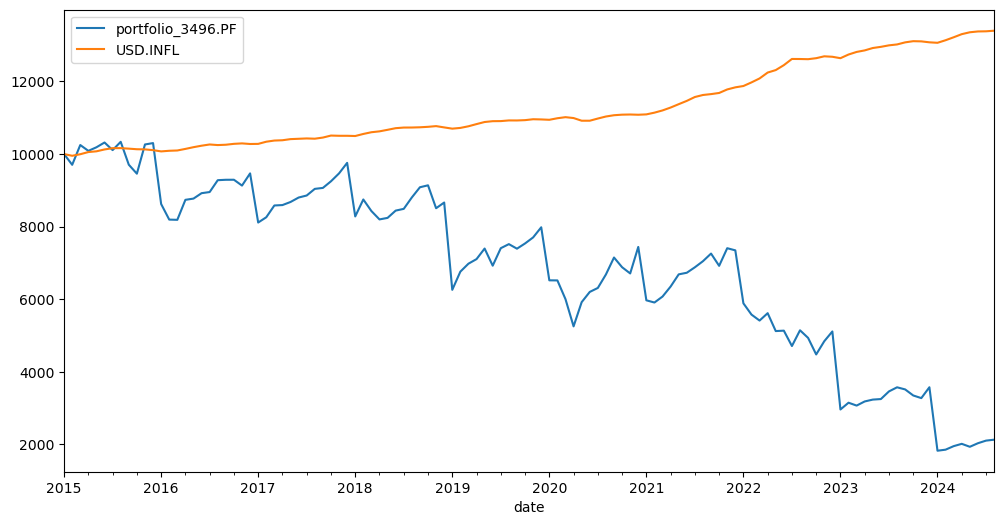

In [96]:
pf.dcf.wealth_index.plot()

In [9]:
df = pf.dcf.monte_carlo_wealth_pv

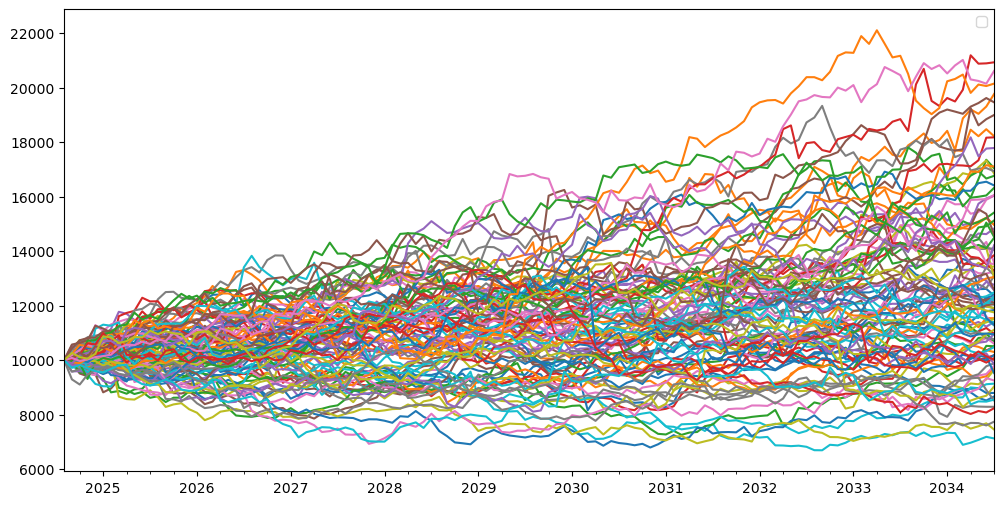

In [11]:
df.plot()
plt.legend("")

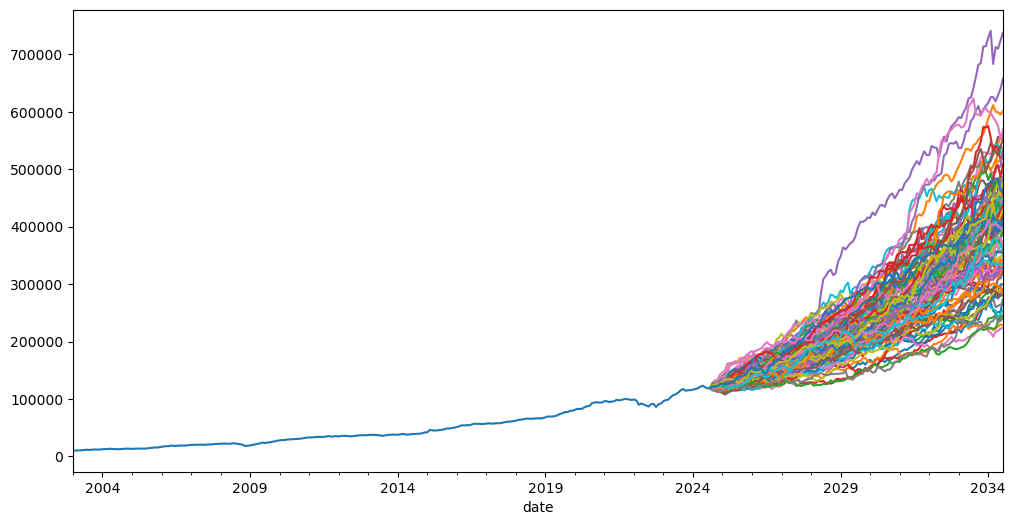

In [13]:
pf.dcf.plot_forecast_monte_carlo(backtest=True)

### find_the_largest_withdrawals_size

In [3]:
assets = ['RGBITR.INDX', 'RUCBTRNS.INDX', 'MCFTR.INDX', 'GC.COMM']
weights = [0.16,          0.40,             0.25,        0.19]
pf = ok.Portfolio(assets, weights=weights, ccy='RUB', rebalancing_strategy='year', inflation=False)
pf.dcf.discount_rate = 0.09
print(pf)

symbol                                                portfolio_5318.PF
assets                [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                         [0.16, 0.4, 0.25, 0.19]
rebalancing_period                                                 year
currency                                                            RUB
inflation                                                          None
first_date                                                      2003-01
last_date                                                       2025-03
period_length                                        22 years, 3 months
dtype: object


In [4]:
ind = ok.IndexationStrategy(pf)
ind.initial_investment = 2_000_000 * 90
ind.amount = -4000 * 90
ind.frequency = "month"
ind.indexation = 0.09

pf.dcf.cashflow_parameters = ind
print(ind)

Portfolio symbol                portfolio_9596.PF
Cash flow initial investment            180000000
Cash flow frequency                         month
Cash flow strategy                   fixed_amount
Cash flow amount                          -360000
Cash flow indexation                      0.09000
dtype: object


In [5]:
ind.amount * 12 / ind.initial_investment * 100

-2.4

In [6]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [7]:
pf.dcf.monte_carlo_survival_period().describe()

count   100.00000
mean     49.03200
std       3.33584
min      32.20000
25%      50.00000
50%      50.00000
75%      50.00000
max      50.00000
dtype: float64

In [8]:
mc_wealth_pv = pf.dcf.monte_carlo_wealth_pv

In [9]:
mc50years_wealth_pv = mc_wealth_pv.iloc[-1, :]
mc50years_wealth_pv.describe([0.05, 0.20, 0.30, 0.50])

count              90.00000
mean      400,707,166.39629
std       331,212,582.94797
min         8,107,953.18626
5%         39,702,834.57472
20%       143,359,085.40553
30%       200,303,716.07043
50%       308,283,047.77550
max     1,797,835,507.07551
Name: 2075-02, dtype: float64

In [11]:
pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",
    percentile=20,
    tolerance_rel=0.10,
)

[autoreload of pydevd failed: Traceback (most recent call last):
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
    
  File "C:\Users\Komov\miniconda3\envs\py311\Lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
    
TypeError: __class__ assignment: 'ThreadsSuspendedSingleNotification' object layout differs from 'ThreadsSuspendedSi

207278783.98273996 -270000.0
error_rel=0.152, gradient=0.000
increasing withdrawal
0.0 -90405000.0
error_rel=1.000, gradient=0.848
decreasing withdrawal


KeyboardInterrupt: 

#### Fixed Percentage

In [7]:
# Fixed Percentage strategy
pc = ok.PercentageStrategy(pf)
pc.initial_investment = 10_000
pc.frequency = "year"
pc.percentage = -0.12
print(pc)

Portfolio symbol                portfolio_5318.PF
Cash flow initial investment                10000
Cash flow frequency                          year
Cash flow strategy               fixed_percentage
Cash flow percentage                     -0.12000
dtype: object


In [ ]:
pf.dcf.cashflow_parameters = pc

In [5]:
pf.dcf.mc.period = 50
pf.dcf.mc.number = 100
pf.dcf.mc.distribution = "norm"

In [8]:
pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",
    percentile=20,
    tolerance_rel=0.10,
    threshold=0.05
)

AttributeError: 'NoneType' object has no attribute 'initial_investment'

## Rolling and expanding risk

In [13]:
al = ok.AssetList(["SPY.US", "BND.US"])
al

assets             [SPY.US, BND.US]
currency                        USD
first_date                  2007-05
last_date                   2024-01
period_length    16 years, 9 months
inflation                  USD.INFL
dtype: object

<Axes: xlabel='date'>

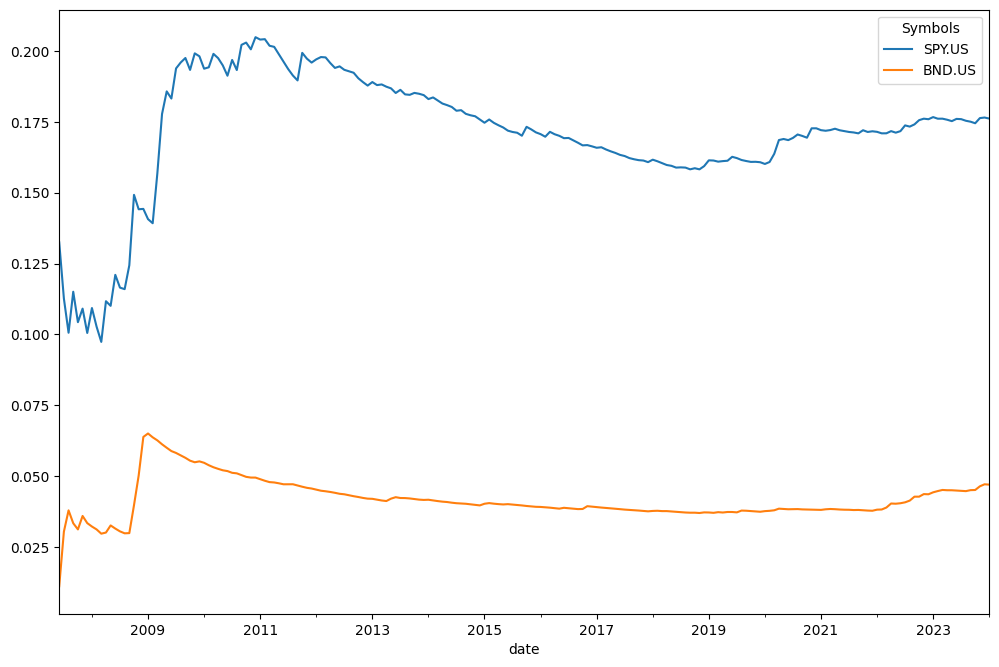

In [9]:
al.risk_annual.plot()

<Axes: xlabel='date'>

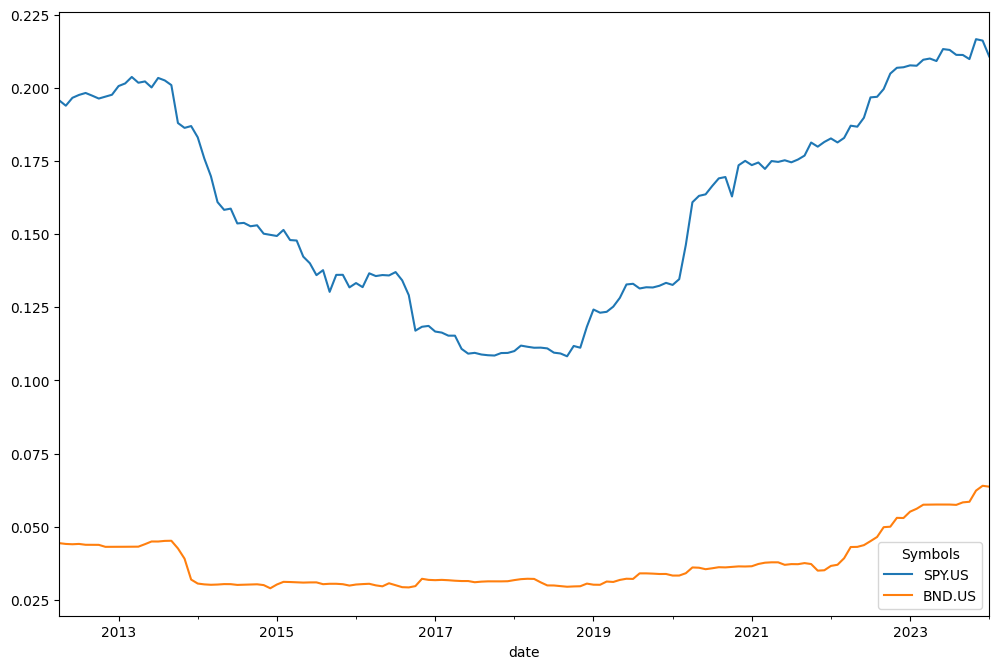

In [10]:
al.get_rolling_risk_annual(window=12 * 5).plot()

In [14]:
al.describe()

C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()
C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()


,property,period,SPY.US,BND.US,inflation
0,Compound return,YTD,0.01590,-0.00160,0.00540
1,CAGR,1 years,0.20603,0.02105,0.03089
2,CAGR,5 years,0.14194,0.00782,0.04148
3,CAGR,10 years,0.12509,0.01565,0.02805
4,CAGR,"16 years, 9 months",0.09404,0.02918,0.02419
5,Annualized mean return,"16 years, 9 months",0.10801,0.03024,NaN
6,Dividend yield,LTM,0.01374,0.03090,NaN
7,Risk,"16 years, 9 months",0.17617,0.04695,NaN
8,CVAR,"16 years, 9 months",0.40832,0.15194,NaN
9,Max drawdowns,"16 years, 9 months",-0.50780,-0.17534,NaN


## Dividends

In [5]:
al = ok.AssetList(["SBERP.MOEX", "LKOH.MOEX"], ccy="RUB")
al

assets           [SBERP.MOEX, LKOH.MOEX]
currency                             RUB
first_date                       2006-09
last_date                        2023-12
period_length         17 years, 4 months
inflation                       RUB.INFL
dtype: object

In [6]:
al.dividends_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.46500,38.00000
2008,0.65000,42.00000
2009,0.63000,50.00000
2010,0.45000,52.00000
2011,1.15000,59.00000
2012,2.59000,115.00000
2013,3.20000,100.00000
2014,3.20000,120.00000
2015,0.45000,159.00000


In [8]:
al.dividend_yield

,SBERP.MOEX,LKOH.MOEX
2006-09,0.00000,0.00000
2006-10,0.00000,0.00000
2006-11,0.00000,0.00000
2006-12,0.00000,0.00000
2007-01,0.00000,0.00000
...,...,...
2023-08,0.09425,0.22437
2023-09,0.09580,0.22950
2023-10,0.09320,0.21406
2023-11,0.09058,0.21095


In [9]:
al.dividend_yield_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


In [11]:
al.dividend_yield.resample(rule="Y").last()

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


<Axes: >

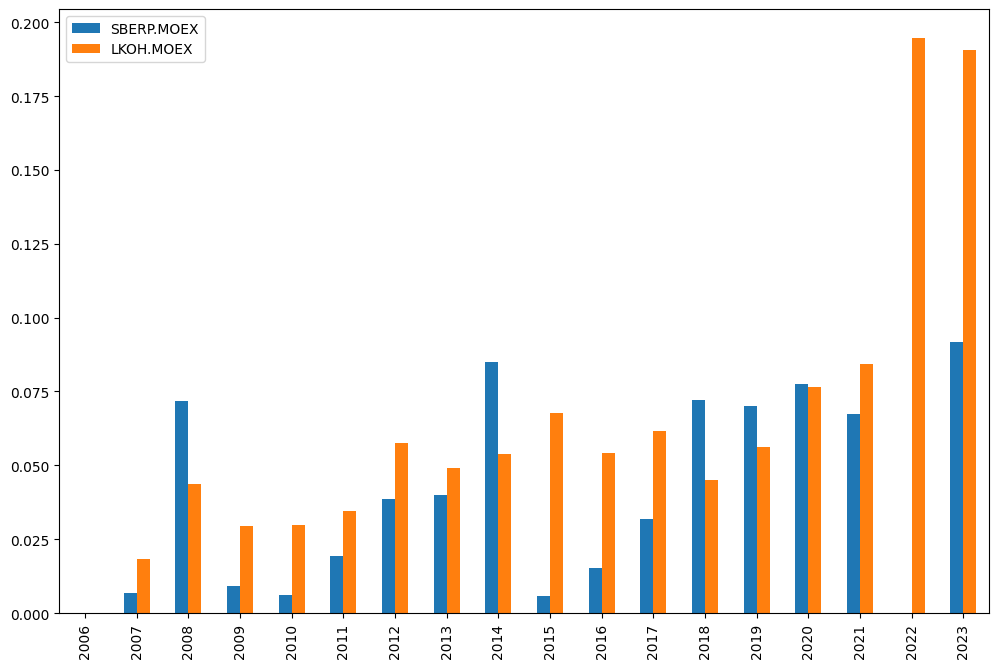

In [12]:
al.dividend_yield_annual.plot(kind="bar")

In [13]:
al.get_dividend_mean_growth_rate()

SBERP.MOEX   -1.00000
LKOH.MOEX     0.28652
dtype: float64

In [14]:
al.get_dividend_mean_yield(10)

SBERP.MOEX   0.05166
LKOH.MOEX    0.08849
dtype: float64

## Plot Wealth

In [15]:
def plot_wealth(
    al: object,
    first_date: str,
    last_date: str,
    legend: list,
    title: str = None,
    logy: bool = False,
    figsize: list = [12, 10],
):
    fig, ax = plt.subplots(figsize=figsize)
    # fig.subplots_adjust(bottom=0.2, top=1.5)
    first_date_dt = pd.to_datetime(first_date)
    last_date_dt = pd.to_datetime(last_date)

    wealth = al.wealth_indexes
    wealth = wealth.loc[first_date:last_date, :]
    index = wealth.index.to_timestamp()
    min_value = wealth.to_numpy().min()
    for i, asset in enumerate(wealth):
        if i == len(wealth.columns) - 1:
            # Inflation is in the last column
            continue
        ax.plot(index, wealth[asset], linewidth=2)
    ax.fill_between(index, min_value, wealth.iloc[:, -1], facecolor="grey", alpha=0.2, label="Инфляция")

    # Log scale
    y_scale = "log" if logy else "linear"
    ax.set_yscale(y_scale)

    # границы графика
    ax.set_xlim(first_date_dt, last_date_dt + pd.DateOffset(months=0))
    ax.set_ylim(bottom=min_value)

    # регулирования надписей оси Х
    years = mdates.YearLocator()  # ежегодный формат
    years_fmt = mdates.DateFormatter("%Y")
    # назначение формата надписей
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    ax.legend(legend + ["Инфляция"], loc="upper left")
    ax.set_title(title)

    # ax.set_ylabel('Инфляция за 12 месяцев, %')

In [16]:
stocks = ok.AssetList(["MCFTR.INDX", "SP500TR.INDX"], ccy="RUB", inflation=False)
stocks

assets           [MCFTR.INDX, SP500TR.INDX]
currency                                RUB
first_date                          1997-10
last_date                           2024-02
period_length            26 years, 5 months
inflation                              None
dtype: object

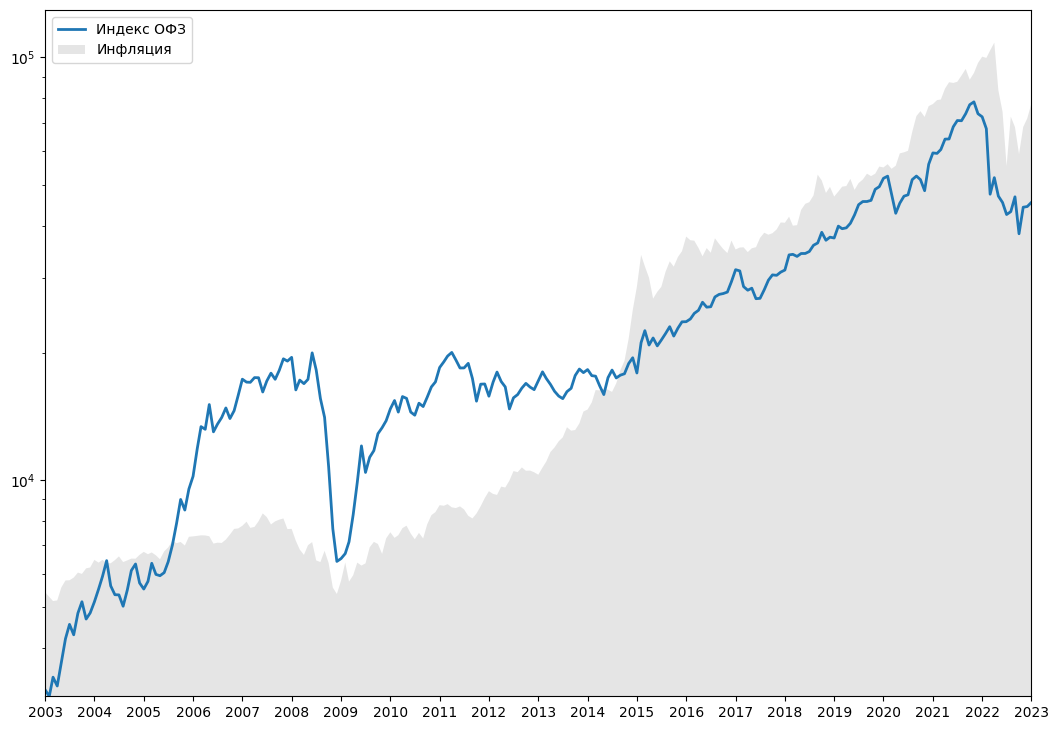

In [17]:
plot_wealth(
    al=stocks, first_date="2003-01", figsize=(14 / 1.1, 10 / 1.1), last_date="2023-01", legend=["Индекс ОФЗ"], logy=True
)